In [1]:
import numpy as np
import pylab as plt
import scipy.spatial.distance as scidist

np.random.seed(1234)

In [2]:
import seaborn as sns
sns.set_palette('bright')

In [3]:
def gen_data(N1=100, N2=100):
    """Generates 2D samples from two Gaussians centered at (1, 1) and (-1, -1).
    
    Parameters:
    N1 (int): Number of samples from Gaussian centered at (1, 1) labeled as 0
    N2 (int): Number of samples from Gaussian centered at (-1, -1) labeled as 1
    
    Returns:
    X: Sample data (D, N)
    Y: Labels (N,)
    """
    X1 = np.random.normal(0, 1, size=(2, N1)) + np.array([[1], [1]])
    X2 = np.random.normal(0, 1, size=(2, N2)) + np.array([[-1], [-1]])
    Y1 = np.zeros((N1,))
    Y2 = np.ones((N2,))
    X = np.hstack((X1, X2))
    Y = np.hstack((Y1, Y2))
    print('X contains %d Examples of Class 1 and %d Examples of Class 2 in %d dimensions.'
          % (X1.shape[1], X2.shape[1], X.shape[0]))
    print('Shape of X: %s' % (X.shape, ))
    print('Shape of Y: %s' % (Y.shape, ))
    return X, Y

In [4]:
print('Generate Train data...')
Xtrain, Ytrain = gen_data()

Generate Train data...
X contains 100 Examples of Class 1 and 100 Examples of Class 2 in 2 dimensions.
Shape of X: (2, 200)
Shape of Y: (200,)


In [5]:
print('Generate Test data...')
Xtest, Ytest = gen_data()

Generate Test data...
X contains 100 Examples of Class 1 and 100 Examples of Class 2 in 2 dimensions.
Shape of X: (2, 200)
Shape of Y: (200,)


In [6]:
def plot_data(X, Y, prefix=''):
    for i in range(int(Y.max())+1):
        plt.scatter(X[0, Y==i], X[1, Y==i], label='%s Class %d' % (prefix, i))

Train data


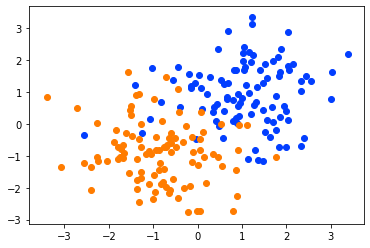

In [7]:
print('Train data')
plot_data(Xtrain, Ytrain)

Test data


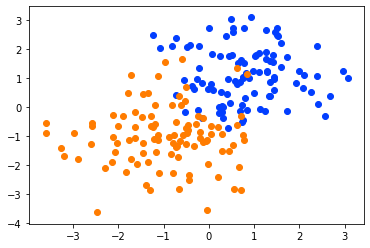

In [8]:
print('Test data')
plot_data(Xtest, Ytest)

In [9]:
"""
    Compute distance to all training points, all 3 do the same thing
    
    Parameters:
    Xa: shape: (D, N)
    Xb: shape: (D, 1)
    
    Returns:
    dist: shape: (N,)
"""
def cdist_single_numpy(Xa, Xb):
    return np.sqrt(((Xa-Xb)**2).sum(0))

def cdist_single_linalg(Xa, Xb):
    return np.linalg.norm(Xa-Xb, axis=0)

def cdist_single_scidist(Xa, Xb):
    return scidist.cdist(Xa.T, Xb.T)[0]  # return shape of cdist is (1, 200)

cdist = cdist_single_numpy
# cdist = cdist_single_linalg
# cdist = cdist_single_scidist

In [10]:
def knn_predict_single(Xtrain, Ytrain, Xquery, k=3):
    """Predict the label of a single data point (Xquery) using k-nearest-neighbors.
    
    Returns:
    Ypred: Predicted label (1,)
    """
    Xquery = Xquery.reshape((Xtrain.shape[0], 1)) # shape of Xquery is (2, 1), this can broadcast
    
    # compute distance to all training points
    dist = cdist(Xtrain, Xquery)

    # find k smallest distances (k nearest neighbors)
    knn_indices = np.argsort(dist)[:k]

    # choose highest voted label
    yvotes = Ytrain[knn_indices]
    yvotes, ycounts = np.unique(yvotes, return_counts=True)
    max_vote = np.argmax(ycounts)
    pred_y = yvotes[max_vote]
    
    return pred_y

Predicted as Class 0


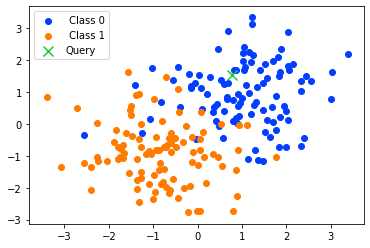

In [11]:
# choose a single sample to query
# Xquery = Xtest[:, 0] # shape of Xquery is (2,) this cannot be broadcast together with shape (2, 200)
Xquery = Xtest[:, 0:1] # shape of Xquery is (2, 1), this can broadcast

pred_y = knn_predict_single(Xtrain, Ytrain, Xquery, k=3)

plot_data(Xtrain, Ytrain)
plt.scatter(Xquery[0], Xquery[1], s=100, marker='x', label='Query')
plt.legend()
print('Predicted as Class %d' % pred_y)

In [12]:
def knn_predict_multi(Xtrain, Ytrain, Xquery, k=3):
    """Predict the label of a single data point (Xquery) using k-nearest-neighbors.
    
    Parameters:
    Xtrain: Train data, shape: (D, N)
    Ytrain: Train labels, shape (D,)
    Xquery: Query data, shape: (D, M)
    
    Returns:
    Ypred: Predicted label (M,)
    """
    
    # compute distance to all training points, this one works for multiple queries
    dist = cdist(Xtrain, Xquery)

    # find k smallest distances (k nearest neighbors)
    knn_indices = np.argsort(dist, axis=0)[:k, :]

    # choose highest voted label
    yvotes = Ytrain[knn_indices]
    y0count = (yvotes == 0).sum(0)
    y1count = (yvotes == 1).sum(0)
    pred_y = (y0count < y1count)
    
    return pred_y

In [13]:
"""
    Compute distance to all training points, all 3 do the same thing
    
    Parameters:
    Xa: shape: (D, N)
    Xb: shape: (D, M)
    
    Returns:
    dist: shape: (N, M)
"""
def cdist_multi_numpy(Xa, Xb):
    # sqrt(|Xa|^2 + |Xb|^2 - 2 Xa^T Xb)
    Xa2 = (Xa**2).sum(0).reshape((-1, 1))
    Xb2 = (Xb**2).sum(0).reshape((1, -1))
    XaXb = np.dot(Xa.T, Xb)
    return np.sqrt(Xa2+Xb2-2*XaXb)
    

def cdist_multi_bad_memory(Xa, Xb):
    Xa = Xa[:, :, np.newaxis]
    Xb = Xb[:, np.newaxis, :]
    return np.sqrt(((Xa-Xb)**2).sum(0))

def cdist_multi_scidist(Xa, Xb):
    return scidist.cdist(Xa.T, Xb.T)  # return shape of cdist is (M, N)

cdist = cdist_multi_numpy
# cdist = cdist_multi_bad_memory
# cdist = cdist_multi_scidist

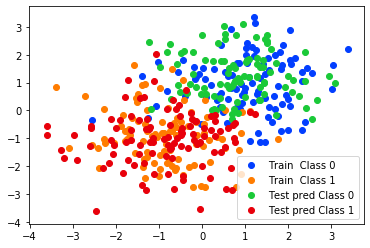

In [14]:
pred_y = knn_predict_multi(Xtrain, Ytrain, Xtest, k=3)

plot_data(Xtrain, Ytrain, prefix='Train ')
plot_data(Xtest, pred_y, prefix='Test pred')
plt.legend()

In [15]:
def draw_model(Xtrain, Ytrain, k=3):
    x = np.linspace(Xtrain[0].min()-1, Xtrain[0].max()+1, 100)
    y = np.linspace(Xtrain[1].min()-1, Xtrain[1].max()+1, 100)
    px, py = np.meshgrid(x, y)
    p = np.vstack((px.flat, py.flat))
    
    pred_y = knn_predict_multi(Xtrain, Ytrain, p, k)
    
    plt.contourf(x, y, pred_y.reshape(100, 100), int(pred_y.max())+1, alpha=0.1, cmap=plt.cm.gray)
    plt.contour(x, y, pred_y.reshape(100, 100), linestyles='-')

KNN boundary for k = 1


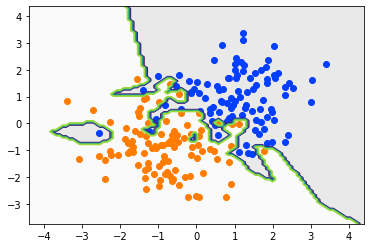

In [16]:
k = 1
print('KNN boundary for k = %d' % k)
draw_model(Xtrain, Ytrain, k=k)
plot_data(Xtrain, Ytrain)

KNN boundary for k = 3


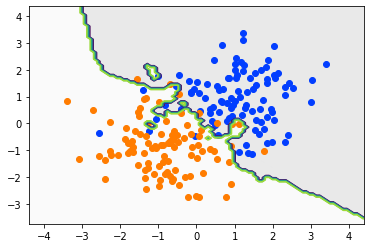

In [17]:
k = 3
print('KNN boundary for k = %d' % k)
draw_model(Xtrain, Ytrain, k=k)
plot_data(Xtrain, Ytrain)

KNN boundary for k = 5


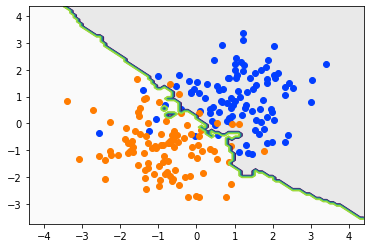

In [18]:
k = 5
print('KNN boundary for k = %d' % k)
draw_model(Xtrain, Ytrain, k=k)
plot_data(Xtrain, Ytrain)